# Testing `pycic`

In [6]:
import numpy as np
import pycic

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Testing `CountMatrix`

In [4]:
# 512 random objects
x = np.random.uniform(0., 500., (512, 3))

# put the objects to a box of length 500 unit
# divide as 4**3 cells 
cm = pycic.CountMatrix(x, 4, 500., )

# count in all cells
cm.countVector()

array([11,  5, 10,  6, 13, 10,  9, 14,  8,  8,  7,  5, 18, 10,  7,  8,  6,
        7, 10,  7,  9, 12,  6,  7,  9,  6, 13,  5,  6, 10, 11,  8,  5,  8,
        8, 10,  8,  8,  7,  6,  8,  9,  5,  4,  8, 11,  9,  7,  6,  7, 10,
        7,  4,  6,  7,  2,  7,  7,  8,  8, 10, 10,  4,  7])

## Testing Catalog object: `CartesianCatalog`

In [3]:
# uniform dist. positions in 500 unit box
x = np.random.uniform(0., 500., (512, 3))

# uniform dist. velocity in [-10, 10]
v = np.random.uniform(-10., 10., (512, 3))

# normally dist. mass 
m = np.random.normal(1.e+5, 5., (512, ))  

# creating the catalog:
cat = pycic.CartesianCatalog(x, v, mass = m, redshift = 0.)
cat

<'CartesianCatalog' of 512 objects>

## Testing CIC Distribution, `cicDistribution`

In [5]:
import lss2

# cosmology object to get power spectrum
cs = lss2.CosmoStructure(Om0 = 0.3, Ob0 = 0.05, sigma8 = 0.8, n = 1., h = 0.7, psmodel = "eisenstein98_zb")

k = np.logspace(-6, 6, 201)
pk = cs.matterPowerSpectrum(k, 0.)

cd = pycic.cicDistribution(
                            np.log(np.stack([k, pk], axis = -1)), # power table
                            0.,                          # redshift
                            cs.Om0, cs.Ode0, cs.h, cs.n, # cosmology param.
                            1.95                         # cellsize
                            )

cd

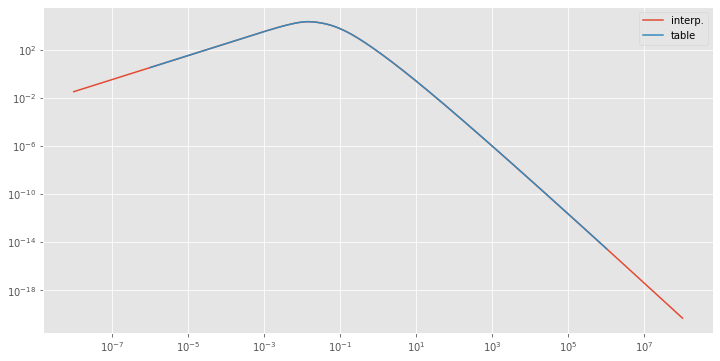

In [11]:
# testing power spectrum:

k1 = np.logspace(-8, 8, 501)
fk = cd.powerLin(np.log(k1))

plt.figure(figsize = (12, 6))
plt.loglog()
plt.plot(k1, fk, label = "interp.")
plt.plot(k, pk, label = "table")
plt.legend()
plt.show()


In [15]:
# variance/bias calculation:

vlin = cd.varLin()
print("linear var. = ", vlin)
print("A var.      = ", cd.varA(vlin)) 
print("bias        = ", cd.biasA(vlin))

linear var. =  5.401181426146088
A var.      =  1.5535116894967078
bias        =  0.5363062769370961
